In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
import mplcyberpunk as cyberpunk

Importing Data

In [2]:
index_names = ['id', 'cycle']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_list=[ "(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]
columns = index_names + setting_names + sensor_list
#print(len(columns))
train = pd.read_csv('train_FD001.txt',sep='\s+',names=columns)
test = pd.read_csv('test_FD001.txt',sep='\s+',header=None,index_col=False,names=columns)
test_res = pd.read_csv('RUL_FD001.txt',sep="\s+",header=None)

Data Cleaning

In [3]:
df_train=train.copy()
df_test=test.copy()

In [4]:
print("Shape of dataset",df_train.shape)
print("Null values in dataset",df_train.isnull().sum())


Shape of dataset (20631, 26)
Null values in dataset id                                         0
cycle                                      0
setting_1                                  0
setting_2                                  0
setting_3                                  0
(Fan inlet temperature) (◦R)               0
(LPC outlet temperature) (◦R)              0
(HPC outlet temperature) (◦R)              0
(LPT outlet temperature) (◦R)              0
(Fan inlet Pressure) (psia)                0
(bypass-duct pressure) (psia)              0
(HPC outlet pressure) (psia)               0
(Physical fan speed) (rpm)                 0
(Physical core speed) (rpm)                0
(Engine pressure ratio(P50/P2)             0
(HPC outlet Static pressure) (psia)        0
(Ratio of fuel flow to Ps30) (pps/psia)    0
(Corrected fan speed) (rpm)                0
(Corrected core speed) (rpm)               0
(Bypass Ratio)                             0
(Burner fuel-air ratio)                    0
(Bl

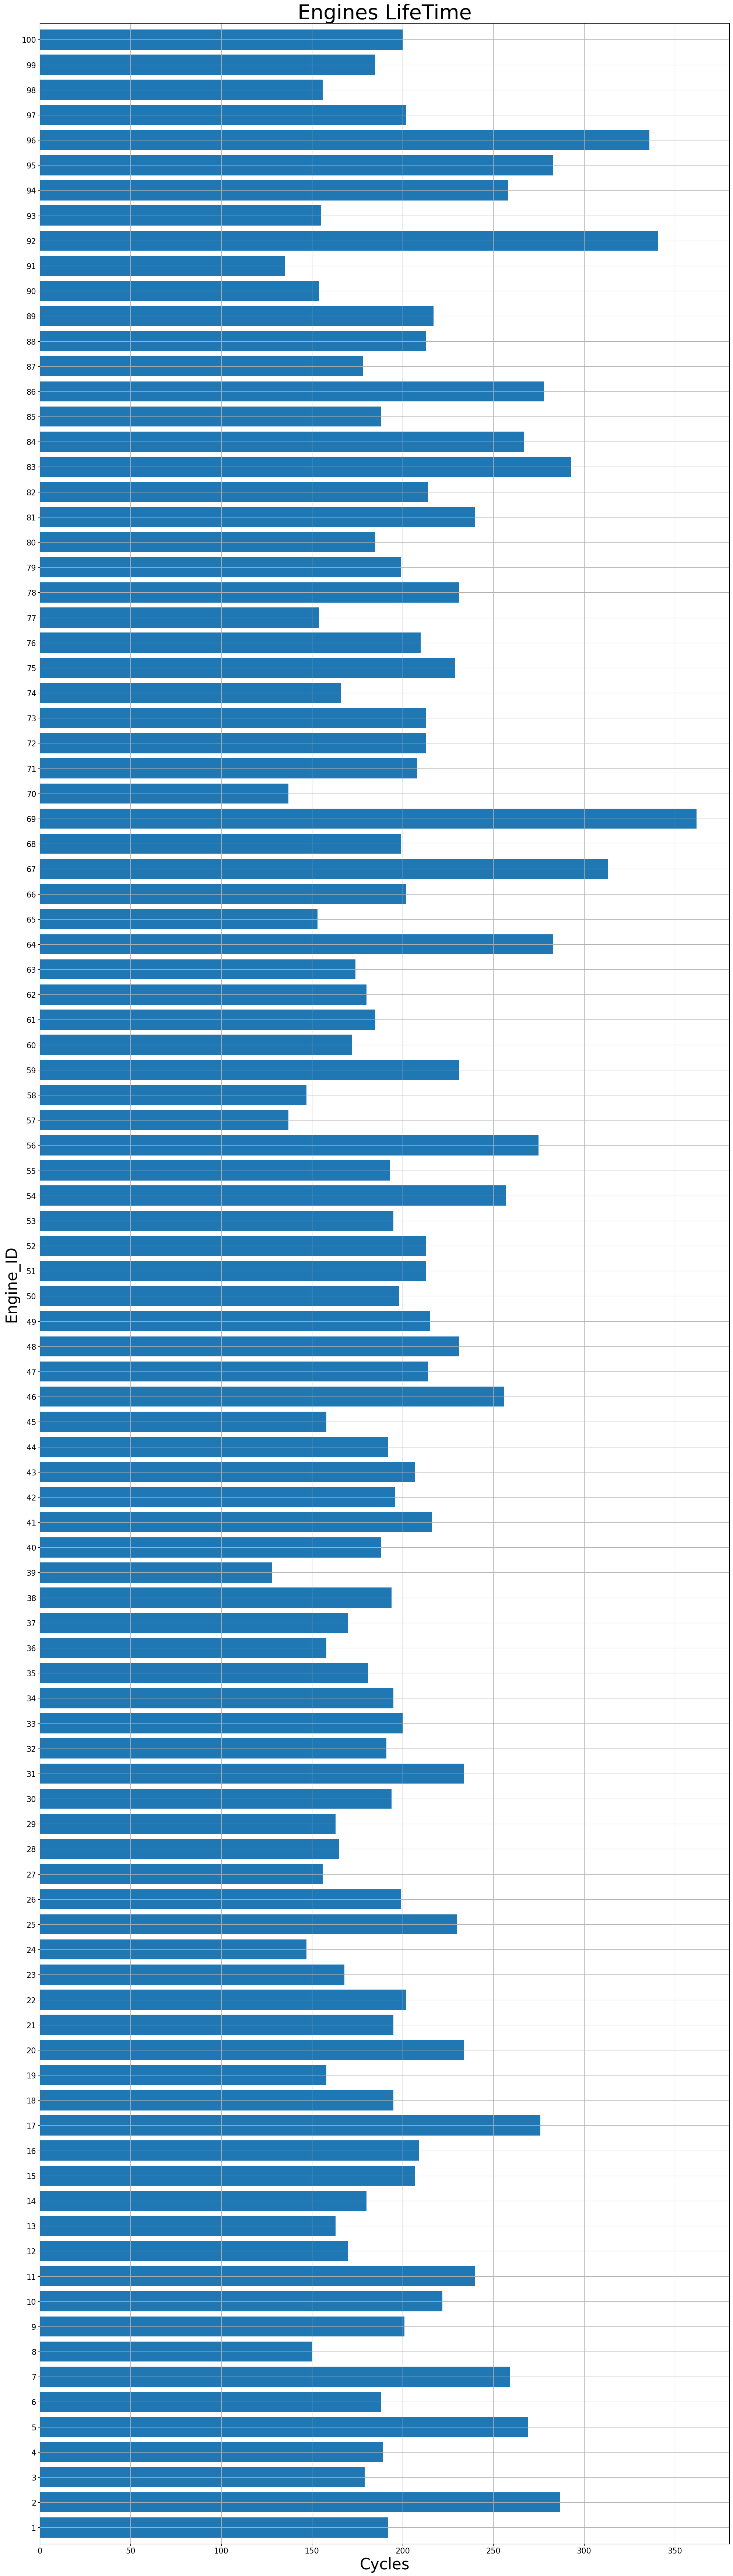

In [5]:

x = df_train[index_names].groupby('id').max()
#print(x)
plt.figure(figsize=(20,70))
ax= x['cycle'].plot(kind='barh',width=0.8)
plt.title('Engines LifeTime',size=40)
plt.xlabel('Cycles',size=30)
plt.xticks(size=15)
plt.ylabel('Engine_ID',size=30)
plt.yticks(size=15)
plt.grid(True)
plt.tight_layout()
plt.show()

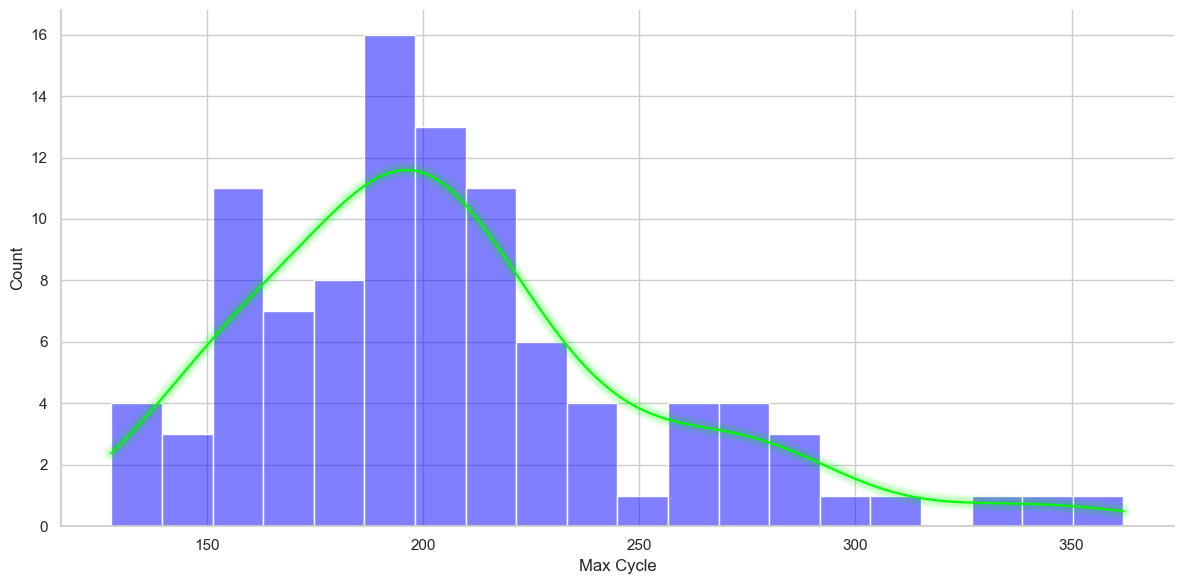

In [6]:
sns.set_theme(style="whitegrid")
sns.displot(x['cycle'], kde=True, bins=20, height=6, aspect=2, color='blue')
plt.gca().lines[0].set_color('lime')
cyberpunk.make_lines_glow()  
plt.xlabel('Max Cycle')
plt.show()

Data Filtering and Treatment

In [7]:
n = len(df_train)
y = list(df_train.groupby(['id'])['cycle'].max())
for i in range(len(y)):
    y[i] = int(y[i])
z = list(df_train['cycle'])
for i in range(n):
    z[i] = int(z[i])
ans = [0]*(n)
for i in range(n):
    ans[i] = y[df_train.iloc[i,0]-1] - z[i]
df_train['RUL'] = ans
train['RUL'] = ans
train

,id,cycle,setting_1,setting_2,setting_3,(Fan inlet temperature) (◦R),(LPC outlet temperature) (◦R),(HPC outlet temperature) (◦R),(LPT outlet temperature) (◦R),(Fan inlet Pressure) (psia),...,(Corrected fan speed) (rpm),(Corrected core speed) (rpm),(Bypass Ratio),(Burner fuel-air ratio),(Bleed Enthalpy),(Required fan speed),(Required fan conversion speed),(High-pressure turbines Cool air flow),(Low-pressure turbines Cool air flow),RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1


In [8]:
rem_col = list()
for i in range(df_train.shape[1]-1):
    cor = df_train["RUL"].corr(df_train.iloc[:,i])
    if -0.001<=cor<=0.001 or np.isnan(cor):
        rem_col.append(df_train.columns[i])
print(rem_col)

['setting_3', '(Fan inlet temperature) (◦R)', '(Fan inlet Pressure) (psia)', '(Engine pressure ratio(P50/P2)', '(Burner fuel-air ratio)', '(Required fan speed)', '(Required fan conversion speed)']


c:\Users\sarsw\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\sarsw\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


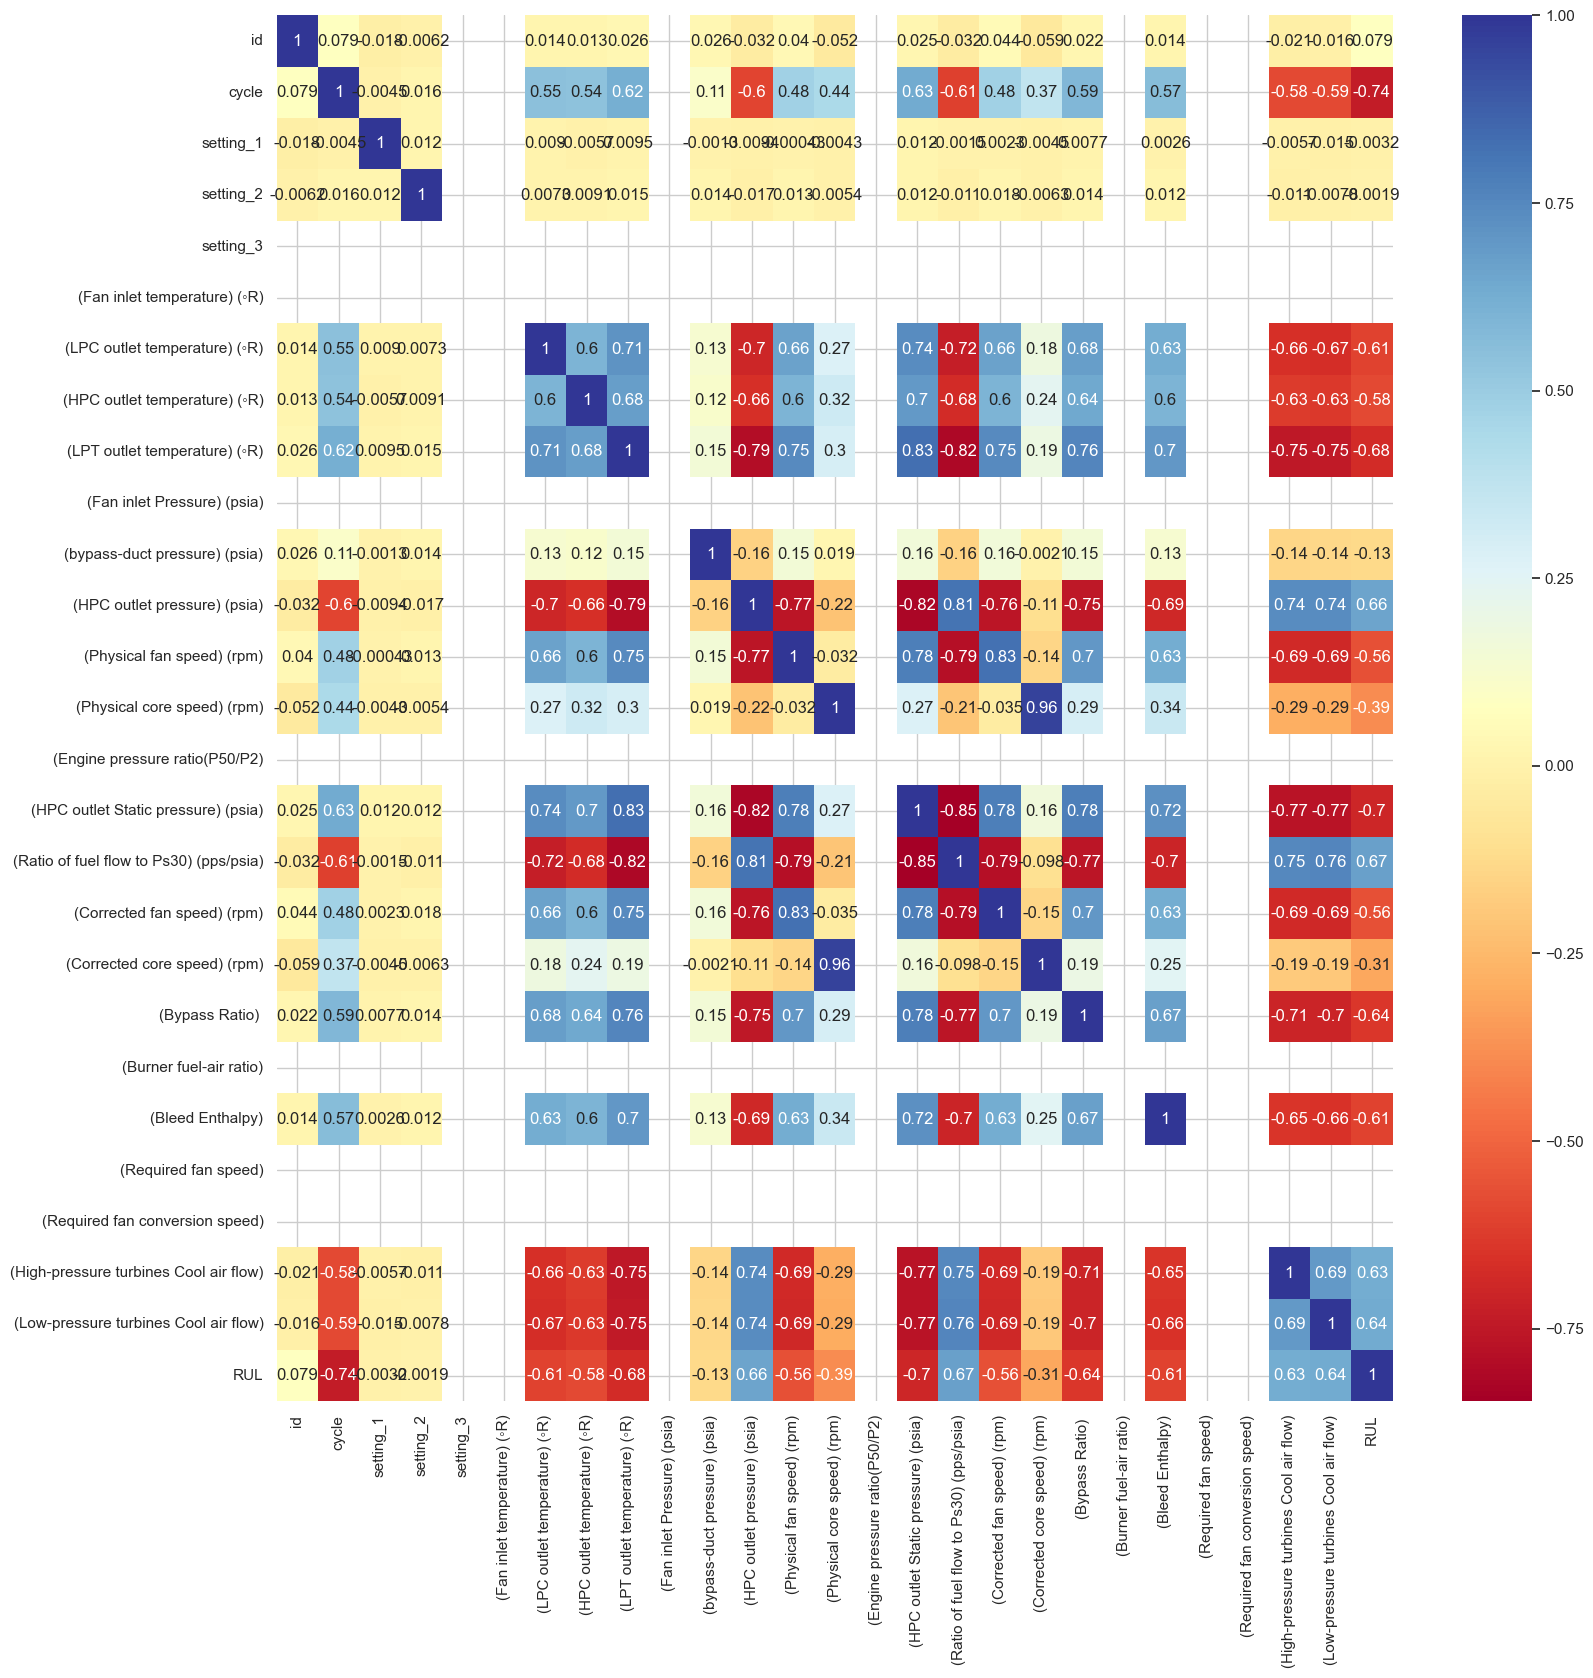

In [9]:
plt.figure(figsize=(18,18))
sns.set_style("whitegrid", {"axes.facecolor": ".0"})
df_cluster2 = df_train.corr()
plot_kws={"s": 1}
sns.heatmap(train.corr(),
            cmap='RdYlBu',
            annot=True,
            linecolor='lightgrey').set_facecolor('white')

**Since correlation of some of the columns are almost zero we will remove them from the dataset for a better training model.**

In [10]:
df_train = df_train.drop(columns=rem_col)
df_train

,id,cycle,setting_1,setting_2,(LPC outlet temperature) (◦R),(HPC outlet temperature) (◦R),(LPT outlet temperature) (◦R),(bypass-duct pressure) (psia),(HPC outlet pressure) (psia),(Physical fan speed) (rpm),(Physical core speed) (rpm),(HPC outlet Static pressure) (psia),(Ratio of fuel flow to Ps30) (pps/psia),(Corrected fan speed) (rpm),(Corrected core speed) (rpm),(Bypass Ratio),(Bleed Enthalpy),(High-pressure turbines Cool air flow),(Low-pressure turbines Cool air flow),RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,643.49,1597.98,1428.63,21.61,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,643.54,1604.50,1433.58,21.61,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3
20628,100,198,0.0004,0.0000,643.42,1602.46,1428.18,21.61,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,643.23,1605.26,1426.53,21.61,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1


Heatmap after removing unwanted columns

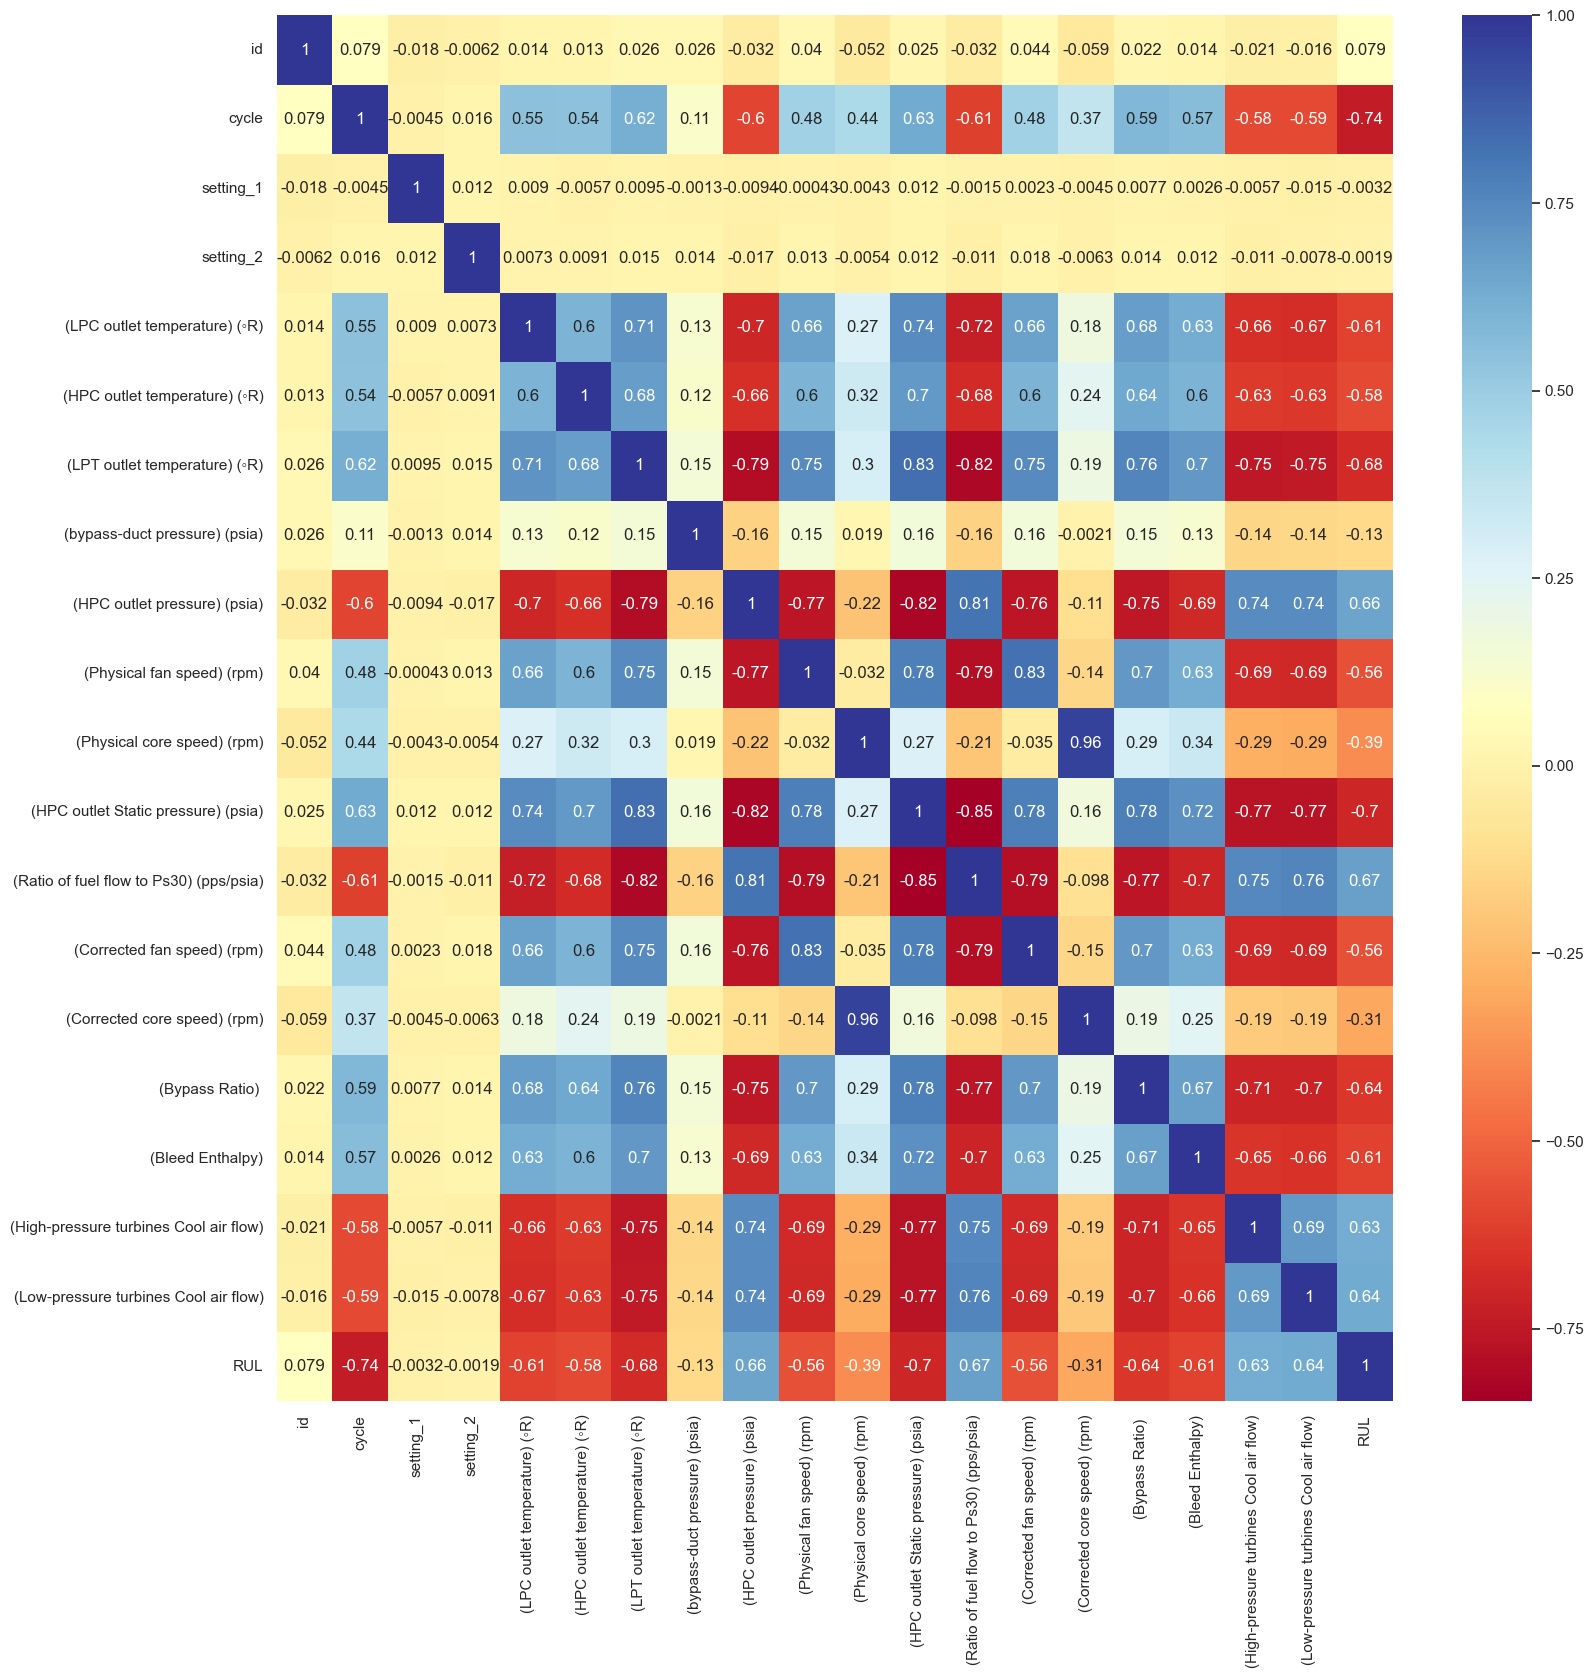

In [11]:
plt.figure(figsize=(18,18))
sns.set_style("whitegrid", {"axes.facecolor": ".0"})
df_cluster2 = df_train.corr()
plot_kws={"s": 1}
sns.heatmap(df_train.corr(),
            cmap='RdYlBu',
            annot=True,
            linecolor='lightgrey').set_facecolor('white')

Heatmap of the dataset showing correlation greater than 0.9.

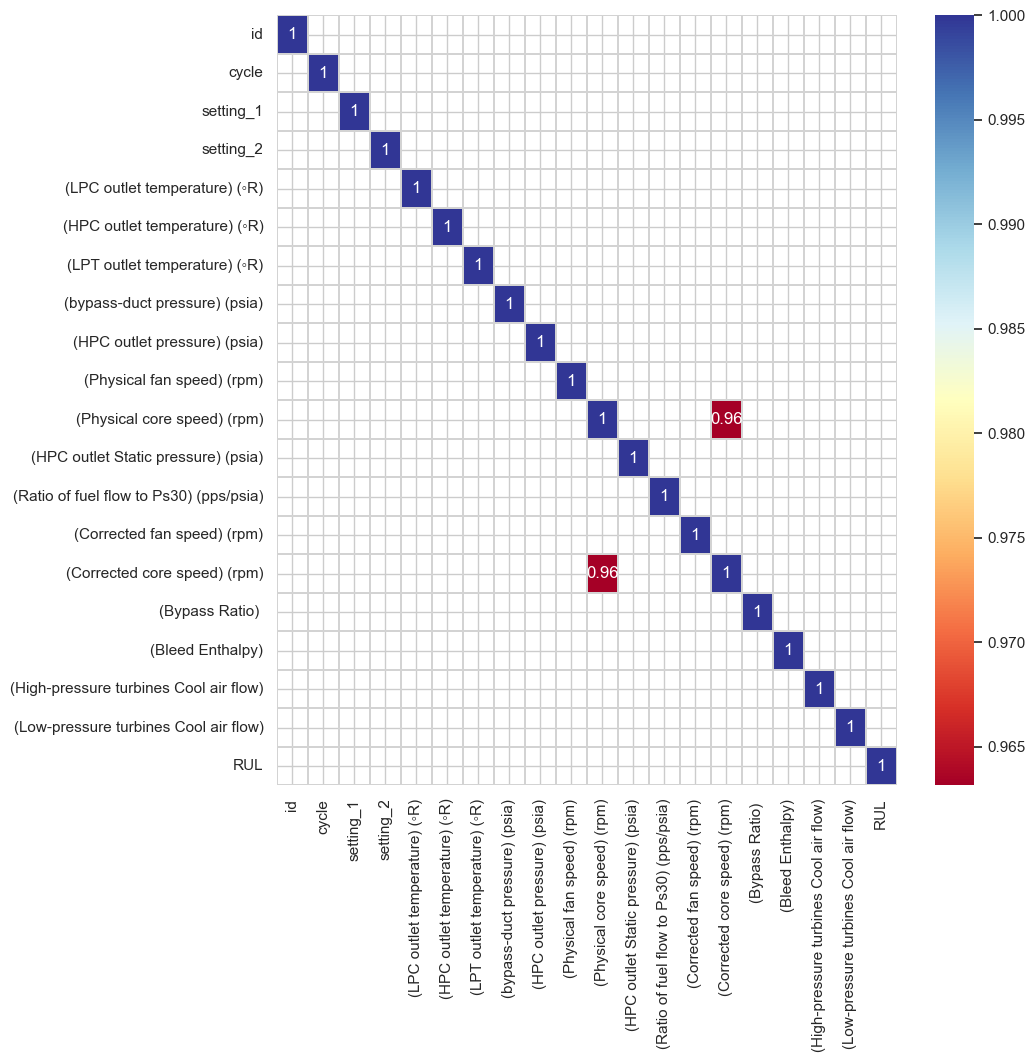

In [12]:
threshold = 0.90
plt.figure(figsize=(10,10))

sns.set_style("whitegrid", {"axes.facecolor": ".0"})
df_cluster2 = df_train.corr()
mask = df_cluster2.where((abs(df_cluster2) >= threshold)).isna()
plot_kws={"s": 1}
sns.heatmap(df_cluster2,
            cmap='RdYlBu',
            annot=True,
            mask=mask,
            linewidths=0.2,
            linecolor='lightgrey').set_facecolor('white')

In [13]:
rem_col_new = []
y =[]
for i in range(df_train.shape[1]):
    for j in range(i+1,df_train.shape[1]):
        corr = df_train.iloc[:,i].corr(df_train.iloc[:,j])
        if abs(corr)>=0.9:
            rem_col_new.append(df_train.columns[j])
rem_col_new

['(Corrected core speed) (rpm)']

In [14]:
df_train = df_train.drop(columns=rem_col_new)
df_train

,id,cycle,setting_1,setting_2,(LPC outlet temperature) (◦R),(HPC outlet temperature) (◦R),(LPT outlet temperature) (◦R),(bypass-duct pressure) (psia),(HPC outlet pressure) (psia),(Physical fan speed) (rpm),(Physical core speed) (rpm),(HPC outlet Static pressure) (psia),(Ratio of fuel flow to Ps30) (pps/psia),(Corrected fan speed) (rpm),(Bypass Ratio),(Bleed Enthalpy),(High-pressure turbines Cool air flow),(Low-pressure turbines Cool air flow),RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8.4294,393,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,643.49,1597.98,1428.63,21.61,551.43,2388.19,9065.52,48.07,519.49,2388.26,8.4956,397,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,643.54,1604.50,1433.58,21.61,550.86,2388.23,9065.11,48.04,519.68,2388.22,8.5139,395,38.30,23.1594,3
20628,100,198,0.0004,0.0000,643.42,1602.46,1428.18,21.61,550.94,2388.24,9065.90,48.09,520.01,2388.24,8.5646,398,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,643.23,1605.26,1426.53,21.61,550.68,2388.25,9073.72,48.39,519.67,2388.23,8.5389,395,38.29,23.0640,1


Columns having 2 unique values with a ratio greater or equal to 0.95 will be removed from the datset for a better training model.

In [15]:
uniq = list(df_train.nunique())
rem_column = []
for i in range(len(uniq)):
    if uniq[i]==2:
        x_un = df_train.iloc[:,i].unique()
        x1 = ((df_train[df_train.columns[i]]==x_un[0]).sum())/df_train.shape[0]
        x2 = ((df_train[df_train.columns[i]]==x_un[1]).sum())/df_train.shape[0]
        if x1/x2>0.95 or x2/x1>0.95:
            rem_column.append(df_train.columns[i])
rem_column

['(bypass-duct pressure) (psia)']

In [16]:
df_train = df_train.drop(columns=rem_column)
df_train

,id,cycle,setting_1,setting_2,(LPC outlet temperature) (◦R),(HPC outlet temperature) (◦R),(LPT outlet temperature) (◦R),(HPC outlet pressure) (psia),(Physical fan speed) (rpm),(Physical core speed) (rpm),(HPC outlet Static pressure) (psia),(Ratio of fuel flow to Ps30) (pps/psia),(Corrected fan speed) (rpm),(Bypass Ratio),(Bleed Enthalpy),(High-pressure turbines Cool air flow),(Low-pressure turbines Cool air flow),RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8.4294,393,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8.4956,397,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8.5139,395,38.30,23.1594,3
20628,100,198,0.0004,0.0000,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8.5646,398,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8.5389,395,38.29,23.0640,1


In [17]:
from sklearn.metrics import mean_squared_error, r2_score

def error(test_res, y_pred):
    mse = mean_squared_error(test_res, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(test_res, y_pred)
    print(f"Mean squared error: {mse}")
    print(f"Root mean squared error: {rmse}")
    print(f"R-squared score: {r2}")
    return [r2,rmse]


In [18]:
r_2_score = []
rmse = []
Method = []

**Linear Regression without dropping features/columns.**

In [19]:
drop_col = ['RUL']

X_train=train.drop(columns=drop_col).copy()
Y_train = df_train["RUL"]

reg = linear_model.LinearRegression()
reg.fit(X_train, Y_train)

LinearRegression()

In [20]:
X_test=test.copy()
ans = reg.predict(X_test)
df_test["Pred_RUL_LR_wrf"] = ans
rem = ["Pred_RUL_LR_wrf"]

In [21]:
y_pred_LR_wrf = list(df_test.groupby(['id'])['Pred_RUL_LR_wrf'].min())
error_LR = error(test_res, y_pred_LR_wrf)
r_2_score.append(error_LR[0])
rmse.append(error_LR[1])
Method.append("LR_wrf")


Mean squared error: 894.8305578921604
Root mean squared error: 29.91371855674517
R-squared score: 0.48181926539666886


**Applying Linear Regression after removing features.**

In [22]:
x_train=df_train.drop(columns=['RUL']).copy()
y_train = df_train["RUL"]
reg = linear_model.LinearRegression()
reg.fit(x_train, y_train)

LinearRegression()

In [23]:
y_test = df_test.drop(columns = rem+rem_col+rem_col_new+rem_column).copy()
lin_pre = reg.predict(y_test)
df_test["Pred_RUL_LR_arf"] = lin_pre

In [24]:
y_pred_LR_arf = list(df_test.groupby(['id'])['Pred_RUL_LR_arf'].min())
f = error(test_res, y_pred_LR_arf)
r_2_score.append(f[0])
rmse.append(f[1])
Method.append("LR_arf")
rem.append("Pred_RUL_LR_arf")

Mean squared error: 890.8276472071307
Root mean squared error: 29.846735955664073
R-squared score: 0.48413728100423403


**Random Forest Regression before removing any features.**

In [25]:
rf = RandomForestRegressor(max_features = "log2")
rf.fit(X_train, Y_train)
ans = rf.predict(X_test)
df_test["Pred_RUL_RF_wrf"] = ans
rem.append("Pred_RUL_RF_wrf")
y_pred_RF_wrf = list(df_test.groupby(['id'])['Pred_RUL_RF_wrf'].min())
f = error(test_res, y_pred_RF_wrf)
r_2_score.append(f[0])
rmse.append(f[1])
Method.append("RF_wrf")


Mean squared error: 576.1797359999999
Root mean squared error: 24.00374420793556
R-squared score: 0.6663443863972125


**Applying Random Forest Regression after removing features**


In [26]:
rf = RandomForestRegressor(max_features = "log2")
rf.fit(x_train, y_train)
pre_rf = rf.predict(y_test)
df_test["Pred_RUL_RF_arf"] = pre_rf
y_pred_RF_arf = list(df_test.groupby(['id'])['Pred_RUL_RF_arf'].min())
f = error(test_res, y_pred_RF_arf)
r_2_score.append(f[0])
rmse.append(f[1])
Method.append("RF_arf")
rem.append("Pred_RUL_RF_arf")

Mean squared error: 651.5577000000001
Root mean squared error: 25.525628297849988
R-squared score: 0.6226943250376287


**KNN before removing features**

In [27]:
model=KNeighborsRegressor(n_neighbors = 24)
model.fit(X_train, Y_train)
ans = model.predict(X_test)
df_test["Pred_RUL_KNN_wrf"] = ans
rem.append("Pred_RUL_KNN_wrf")
y_pred_KNN_wrf = list(df_test.groupby(['id'])['Pred_RUL_KNN_wrf'].min())
f = error(test_res, y_pred_KNN_wrf)
r_2_score.append(f[0])
rmse.append(f[1])
Method.append("KNN_wrf")

Mean squared error: 969.0081597222222
Root mean squared error: 31.128895896292597
R-squared score: 0.4388643127875884


**KNN after removing features**

In [28]:
model = KNeighborsRegressor(n_neighbors = 78)
model.fit(x_train, y_train)
pre_KNN = model.predict(y_test)
df_test["Pred_RUL_KNN_arf"] = pre_KNN
y_pred_KNN_arf = list(df_test.groupby(['id'])['Pred_RUL_KNN_arf'].min())
f = error(test_res, y_pred_KNN_arf)
r_2_score.append(f[0])
rmse.append(f[1])
Method.append("KNN_arf")
rem.append("Pred_RUL_KNN_arf")

Mean squared error: 940.5797731755424
Root mean squared error: 30.66887303399886
R-squared score: 0.45532669451385177


**Gradient Boosting Regression before removing features**

In [29]:
model=GradientBoostingRegressor(loss = "absolute_error",criterion = "squared_error",max_features = "sqrt")
model.fit(X_train, Y_train)
ans = model.predict(X_test)
df_test["Pred_RUL_GB_wrf"] = ans
rem.append("Pred_RUL_GB_wrf")
y_pred_GB_wrf = list(df_test.groupby(['id'])['Pred_RUL_GB_wrf'].min())
f = error(test_res, y_pred_GB_wrf)
r_2_score.append(f[0])
rmse.append(f[1])
Method.append("GB_wrf")

Mean squared error: 549.1271065841099
Root mean squared error: 23.433461259150555
R-squared score: 0.6820100912170148


**Gradient Boosting Regression after removing features**


In [30]:
model=GradientBoostingRegressor(loss = "absolute_error",criterion = "squared_error",max_features = "log2")
model.fit(x_train, y_train)
pre_KNN = model.predict(y_test)
df_test["Pred_RUL_GBR_arf"] = pre_KNN
y_pred_GB_arf = list(df_test.groupby(['id'])['Pred_RUL_GBR_arf'].min())
f = error(test_res, y_pred_GB_arf)
r_2_score.append(f[0])
rmse.append(f[1])
Method.append("GBR_arf")
rem.append("Pred_RUL_GBR_arf")

Mean squared error: 571.646562441639
Root mean squared error: 23.909131361085436
R-squared score: 0.6689694679658271


**Deciding the final regression method for prediction**

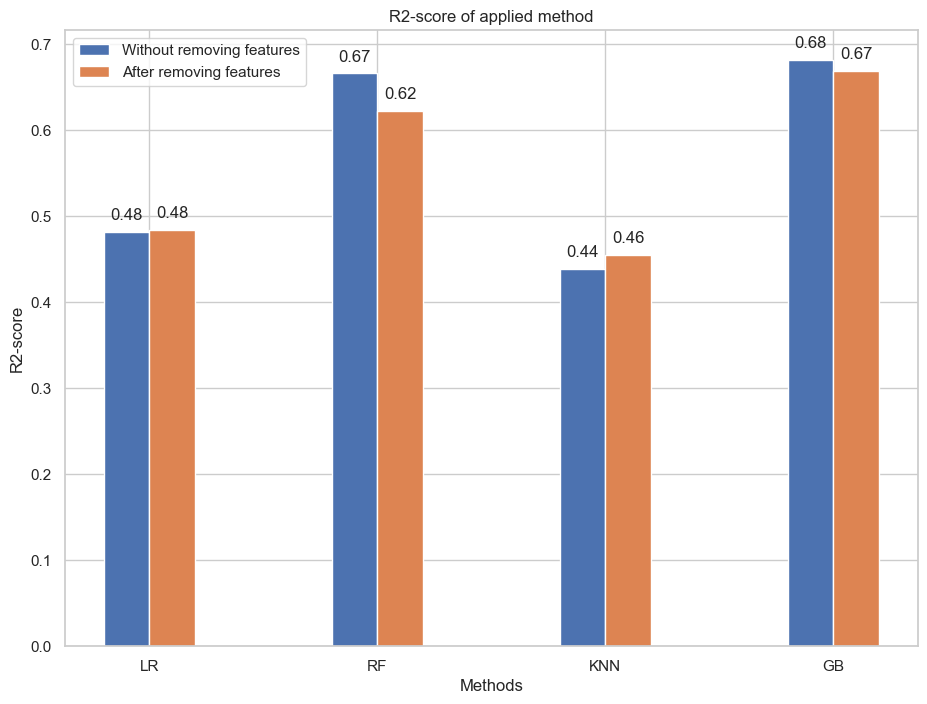

In [31]:
import numpy as np
import matplotlib.pyplot as plt
method = ["LR","RF","KNN","GB"]
X_axis = np.arange(len(method))
r2_score_wr = r_2_score[::2]
r2_score_r = r_2_score[1::2]
plt.figure(figsize = (11,8))
plt.bar(X_axis - 0.1, r2_score_wr, 0.2, label='Without removing features')
plt.bar(X_axis + 0.1, r2_score_r, 0.2, label='After removing features')

plt.xticks(X_axis, method)
plt.xlabel("Methods")
plt.ylabel("R2-score")
plt.title("R2-score of applied method")
plt.legend(facecolor='white')

for i in range(len(X_axis)):
    plt.text(X_axis[i] - 0.1, r2_score_wr[i] + 0.01, "{:.2f}".format(r2_score_wr[i]), ha='center', va='bottom')
    plt.text(X_axis[i] + 0.1, r2_score_r[i] + 0.01, "{:.2f}".format(r2_score_r[i]), ha='center', va='bottom')

plt.gca().set_facecolor('white')

plt.show()

In [32]:
maxi = r_2_score.index(max(r_2_score))
print("Maximum R2-score",max(r_2_score))
print("Best Regression method for this dataset is:",Method[maxi])

Maximum R2-score 0.6820100912170148
Best Regression method for this dataset is: GB_wrf


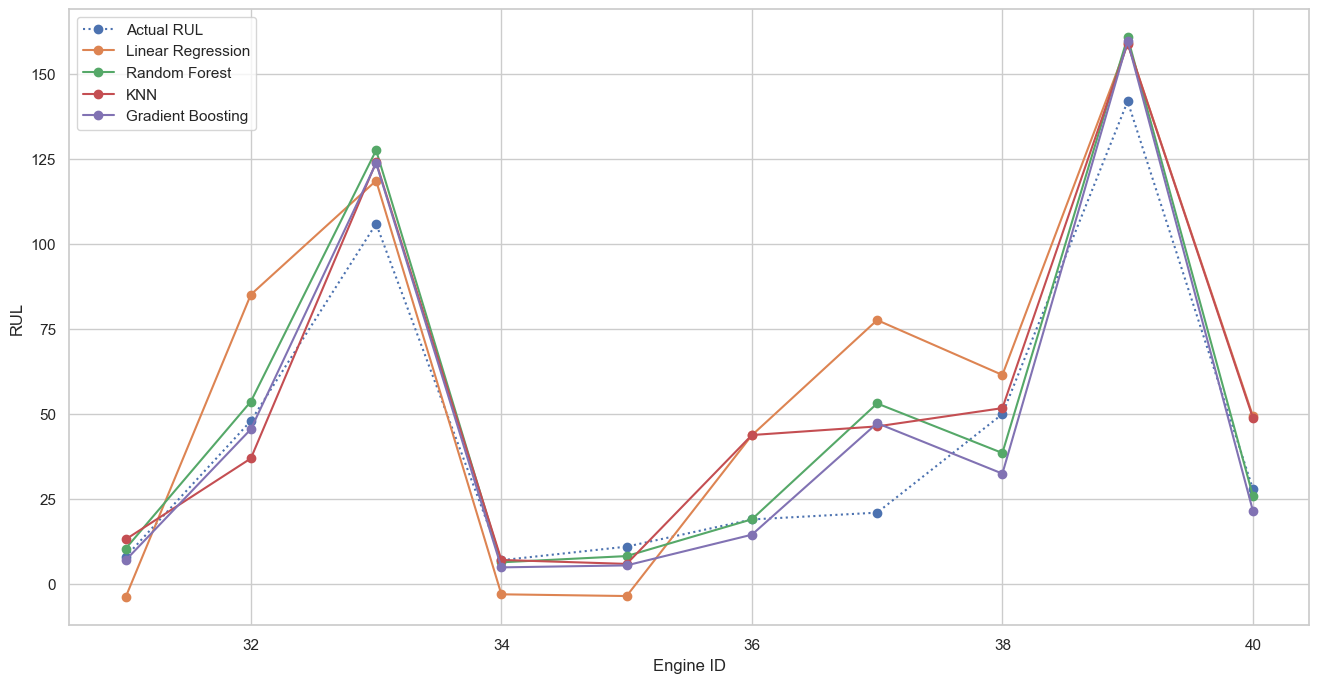

In [33]:
x=[0]*(len(test_res))
for i in range(len(test_res)):
    x[i]=i+1
import matplotlib.pyplot as plt


plt.figure(figsize = (16,8))

plt.xlabel('Engine ID')
plt.ylabel('RUL')
plt.plot(x[30:40], test_res.iloc[30:40,0], label='Actual RUL',linestyle='dotted',marker='o')
plt.plot(x[30:40], y_pred_LR_wrf[30:40], label='Linear Regression',marker='o')
plt.plot(x[30:40], y_pred_RF_wrf[30:40], label='Random Forest',marker='o')
plt.plot(x[30:40], y_pred_KNN_wrf[30:40], label='KNN',marker='o')
plt.plot(x[30:40], y_pred_GB_wrf[30:40], label='Gradient Boosting',marker='o')

plt.legend(facecolor='white')
plt.gca().set_facecolor('white')
plt.show()


In [34]:
df_test

,id,cycle,setting_1,setting_2,setting_3,(Fan inlet temperature) (◦R),(LPC outlet temperature) (◦R),(HPC outlet temperature) (◦R),(LPT outlet temperature) (◦R),(Fan inlet Pressure) (psia),...,(High-pressure turbines Cool air flow),(Low-pressure turbines Cool air flow),Pred_RUL_LR_wrf,Pred_RUL_LR_arf,Pred_RUL_RF_wrf,Pred_RUL_RF_arf,Pred_RUL_KNN_wrf,Pred_RUL_KNN_arf,Pred_RUL_GB_wrf,Pred_RUL_GBR_arf
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,38.86,23.3735,169.239221,168.749755,182.47,182.12,193.333333,204.012821,187.406009,190.950612
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,39.02,23.3916,174.897895,175.472100,202.03,200.26,219.291667,210.141026,200.988608,191.945012
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,39.08,23.4166,161.413240,160.778057,181.27,182.39,201.875000,209.756410,180.152234,179.075094
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,39.00,23.3737,166.823728,167.536591,183.73,182.24,191.208333,186.705128,189.544702,181.283718
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,38.99,23.4130,173.569106,173.922341,195.34,197.39,188.083333,190.371795,204.668115,190.246553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,38.65,23.1974,48.342431,48.807631,30.66,36.37,16.791667,15.217949,18.937058,14.204844
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,38.57,23.2771,48.786880,49.248393,29.07,35.07,14.958333,15.897436,28.283875,20.248149
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,38.62,23.2051,51.184381,51.841895,34.58,36.63,19.500000,15.512821,26.066148,25.409654
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,38.66,23.2699,48.200992,48.944815,28.91,34.96,15.083333,12.884615,26.389945,19.687997
